# Implement a tiny version of YOLO with DIOR dataset

## 1. Import libraries

In [1]:
import os
import shutil
import gdown
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from xml.etree import ElementTree
from activations import SquareActivation
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary


/home/ec2-user/ObjDct_Master_Thesis/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Import Data

In [ ]:
raw_data_path = "raw_data"

In [ ]:
if os.path.exists(raw_data_path):
    print('[INFO] Raw data directory exists, skiping download.')
else:
    os.makedirs(raw_data_path)
    print('[INFO] Raw data directory is been created.')
    print('[INFO] Downloading data...\n')
    gdown.download('https://drive.google.com/uc?id=1KoQzqR20qvIXDf1qsXCHGxD003IPmXMw', output=os.path.join(raw_data_path, 'Annotations.zip'))
    gdown.download('https://drive.google.com/file/d/1wq0FQCBsbrnf-sJfloi7IR9tBH87GGGS/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-test.zip'),fuzzy=True)
    gdown.download('https://drive.google.com/file/d/1NVRSBm3RfpGGtZvgLJG5e_XD9uP4DZmI/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-trainval.zip'),fuzzy=True)
    print('[INFO] Data is been downloaded.')

In [ ]:
dior_data_path = "dior_data"

In [ ]:
# Extracting the zip data files
if os.path.exists(dior_data_path):
    print('[INFO] DIOR data directory exists, skiping extraction.')
else:
    os.makedirs(dior_data_path)
    for i in os.listdir(raw_data_path):
        filename = os.path.join(raw_data_path, i) 
        shutil.unpack_archive(filename=filename, extract_dir=dior_data_path)
        print(f'[INFO] File "{filename}" is been extracted to "{dior_data_path}".')

In [ ]:
# Path for all the data
annot_data_path = 'dior_data/Annotations/Horizontal Bounding Boxes'
trainval_data_path = 'dior_data/JPEGImages-trainval'
test_data_path = 'dior_data/JPEGImages-test'

In [ ]:
# Creating a list of annotation files
annot_file_list = sorted([os.path.join(annot_data_path, i) for i in os.listdir(annot_data_path) if '.xml' in i])
annot_file_list[:5], annot_file_list[-5:], len(annot_file_list)

In [ ]:
# Creating a list of training and validation images
trainval_file_list = sorted([os.path.join(trainval_data_path, i) for i in os.listdir(trainval_data_path) if '.jpg' in i])
trainval_file_list[:5], trainval_file_list[-5:], len(trainval_file_list)

In [ ]:
# Creating a list of testing images
test_file_list = sorted([os.path.join(test_data_path, i) for i in os.listdir(test_data_path) if '.jpg' in i])
test_file_list[:5], test_file_list[-5:], len(test_file_list)

In [ ]:
# Combining all the images path in one list
image_data_file_list = np.concatenate((trainval_file_list, test_file_list))
image_data_file_list[:5], image_data_file_list[-5:], len(image_data_file_list)

## 3. Data analysis

In [ ]:
# Extracting data from annotation files
meta_list = [] # To store general info for every image
object_list_train = [] # To store object classes info of train dataset
object_list_test = [] # To store object classes info of test dataset

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()
    
    # Filename - extracted
    for path in image_data_file_list:
        if root.find('filename').text in path:
            meta_dict['filename'] = path
            meta_dict['split_type'] = path.split('/')[1]
    
    # Width - extracted
    meta_dict['width'] = int(root.find('size').find('width').text)
    
    # Height - extracted
    meta_dict['height'] = int(root.find('size').find('height').text)
    
    # Objects - extracted and combined into a single string
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)
    
    # Collecting all the object classes instance and counting total appearance
    for obj in root.findall('object'):
        if meta_dict['split_type'] == 'JPEGImages-trainval':
            object_list_train.append(obj.find('name').text)
        elif meta_dict['split_type'] == 'JPEGImages-test':
            object_list_test.append(obj.find('name').text)
    
# Counting the instance for every object class
object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))
    
# Collecting Class list and indexing it also in a sequence
class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}

meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict

In [ ]:
# Creating a dataframe from the extracted data
meta_df = pd.DataFrame(meta_list)
meta_df

In [ ]:
print(f'Size of the images width: {meta_df.width.unique()[0]} and height: {meta_df.height.unique()[0]}')
print(f'Total number of classes with all possible combination: {len(meta_df.objects.unique())}')
print(f'Total length of the training/validation dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-trainval"])} and testing dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-test"])}')

In [ ]:
# Top 20 classes in the dataset
meta_df.objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Top 20 Objects Classes')

In [ ]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
meta_df[meta_df["split_type"] == "JPEGImages-trainval"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
meta_df[meta_df["split_type"] == "JPEGImages-test"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Top 20 Objects Classes in the Dataset', fontsize=20, fontweight='bold')

In [ ]:
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 1)
plt.barh(list(object_instance_list_train.keys()), list(object_instance_list_train.values()))
plt.xlabel('Objects (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
plt.barh(list(object_instance_list_test.keys()), list(object_instance_list_test.values()))
plt.xlabel('Objects (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Total Count of Object Instances Per Class in the Dataset', fontsize=20, fontweight='bold');

In [ ]:
# Visualizing the classes - rerun the code for different classes.
viz_class = random.sample(meta_df.objects.tolist(), 1)[0]
viz_list = meta_df[meta_df['objects'] == viz_class].filename.tolist()
plt.figure(figsize=(20, 5))
rand = random.sample(viz_list, 4)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(rand[i]))
    plt.suptitle(f'Objects in the Image: {viz_class}', fontsize=20, fontweight='bold')
    plt.axis(False)

## 4. Convert annotation to YOLO format

In [ ]:
# Creating a function for extracting data
def extract_data_from_xml(xml_file: str):
    """
    A function to extract data like filename, size, classes and bboxes from xml file.
    
    Parameters: xml_file: str, A string containing the path to the file.
    
    Returns: data_dict: dict, A dict containing all the extracted data.
    """
    root = ElementTree.parse(xml_file).getroot()
    
    # Creating dict and list to store data
    data_dict = {}
    data_dict['bboxes'] = []
    
    # Reading the xml file
    for element in root:
        # Getting the filename
        if element.tag == 'filename':
            data_dict['filename'] = element.text
        
        # Getting the image size
        elif element.tag == 'size':
            image_size = []
            for size_element in element:
                image_size.append(int(size_element.text))
            data_dict['image_size'] = image_size
        
        # Getting the bounding box
        elif element.tag == 'object':
            bbox = {}
            for obj_element in element:
                # Object or Class name
                if obj_element.tag == 'name':
                    bbox['class'] = obj_element.text
                # Object bounding box 
                elif obj_element.tag == 'bndbox':
                    for bbox_element in obj_element:
                        bbox[bbox_element.tag] = int(bbox_element.text)
            data_dict['bboxes'].append(bbox)
    return data_dict

In [ ]:
example = extract_data_from_xml(annot_file_list[1])
example

In [ ]:
# Creating a function to create a YOLO format annotation
def convert_dict_to_yolo(data_dict: dict):
    """
    A function to convert the extracted data dict into a text file as per the YOLO format.
    The final text file is saved in the directory "dior_data/yolo_annotations/data_dict['filename'].txt".
    
    Parameters: data_dict: dict, A dict containing the data.
    """
    data = []
    
    # Reading the bounding box data
    for bbox in data_dict['bboxes']:
        try:
            class_id = class_dict[bbox['class']]
        except KeyError:
            print(f'Invalid Class. Object class: "{bbox["class"]}" not present in the class list.')
            
        # Transforming the bbox in Yolo format [X, Y, W, H]
        img_w, img_h, _ = data_dict['image_size'] # Normalizing the bbox using image size
        
        x_center = ((bbox['xmin'] + bbox['xmax']) / 2) / img_w
        y_center = ((bbox['ymin'] + bbox['ymax']) / 2) / img_h
        width = (bbox['xmax'] - bbox['xmin']) / img_w 
        height = (bbox['ymax'] - bbox['ymin']) / img_h
        
        # Writing the new data to the data list in Yolo format
        data.append(f'{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}')
        
    # File name for saving the text file(same as xml and jpg file name)
    yolo_annot_dir = os.path.join('dior_data', 'yolo_annotations')
    if not os.path.exists(yolo_annot_dir):
        os.makedirs(yolo_annot_dir)
    save_file_name = os.path.join(yolo_annot_dir, data_dict['filename'].replace('jpg', 'txt'))
    
    # Saving the yolo annotation in a text file
    f = open(save_file_name, 'w+')
    f.write('\n'.join(data))
    f.close()

In [ ]:
# Converting all the xml files into Yolo format text files
print('[INFO] Annotation extraction and creation into Yolo has started.')
for annot_file in tqdm(annot_file_list):
    data_dict = extract_data_from_xml(annot_file)
    convert_dict_to_yolo(data_dict)
print('[INFO] All the annotation are converted into Yolo format.')

In [ ]:
yolo_annot_path = 'dior_data/yolo_annotations'
yolo_annot_file_list = sorted([os.path.join(yolo_annot_path, i) for i in os.listdir(yolo_annot_path) if '.txt' in i])
yolo_annot_file_list[:5], yolo_annot_file_list[-5:], len(yolo_annot_file_list)

In [ ]:
class_dict_idx = dict(zip(class_dict.values(), class_dict.keys()))
class_dict_idx

In [ ]:
def plot_bboxes(img_file: str, annot_file: str, class_dict: dict):
    """
    A function to plot the bounding boxes amd their object classes onto the image.
    
    Parameters:
        img_file: str, A string containing the path to the image file.
        annot_file: str, A string containing the path to the annotation file in yolo format.
        class_dict: dict, A dict containing the classes in the similar sequence as per the annot_file.
    """
    # Reading the image and annot file
    image = cv2.imread(img_file)
    img_h, img_w, _ = image.shape
    
    with open(annot_file, 'r') as f:
        data = f.read().split('\n')
        data = [i.split(' ') for i in data]
        data = [[float(j) for j in i] for i in data]
    
    # Calculating the bbox in Pascal VOC format
    for bbox in data:
        class_idx, x_center, y_center, width, height = bbox
        xmin = int((x_center - width / 2) * img_w)
        ymin = int((y_center - height / 2) * img_h)
        xmax = int((x_center + width / 2) * img_w)
        ymax = int((y_center + height / 2) * img_h)
        
        # Correcting bbox if out of image size
        if xmin < 0:
            xmin = 0
        if ymin < 0:
            ymin = 0
        if xmax > img_w - 1:
            xmax = img_w - 1
        if ymax > img_h - 1:
            ymax = img_h - 1
        
        # Creating the box and label for the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
        cv2.putText(image, class_dict[class_idx], (xmin, 0 if ymin-10 < 0 else ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
    
    # Displaying the image
    plt.imshow(image)
    plt.axis(False)

In [ ]:
plt.figure(figsize=(25, 8))
rand_int = random.sample(range(len(yolo_annot_file_list)), 3)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_bboxes(image_data_file_list[rand_int[i]], yolo_annot_file_list[rand_int[i]], class_dict_idx)

## 5. Implement YOLO architecture

In [2]:
class TinyYOLOv1(nn.Module):
    def __init__(self, B=2, num_classes=20):
        super(TinyYOLOv1, self).__init__()
        S = 7  # grid size
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            SquareActivation(),
            nn.BatchNorm2d(8),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            SquareActivation(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=1, stride=1), # 1x1 convolution to reduce the depth
            SquareActivation(),
            nn.BatchNorm2d(8),  
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()  # Add flatten layer
        self.fc1 = nn.Linear(5000, 2048)  # Update input size of fc1 layer
        self.square_activation = SquareActivation()  # Add SquareActivation()
        self.fc2 = nn.Linear(2048, S * S * (B * 5 + num_classes))  # Reduced number of neurons

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)  # Flatten the output
        x = self.fc1(x)
        x = self.square_activation(x)  # Apply SquareActivation()
        x = self.fc2(x)
        return x

model = TinyYOLOv1()

In [3]:
summary(model, input_size=(1,3,800,800))


Layer (type:depth-idx)                   Output Shape              Param #
TinyYOLOv1                               [1, 1470]                 --
├─Sequential: 1-1                        [1, 8, 25, 25]            --
│    └─Conv2d: 2-1                       [1, 8, 400, 400]          224
│    └─SquareActivation: 2-2             [1, 8, 400, 400]          --
│    └─BatchNorm2d: 2-3                  [1, 8, 400, 400]          16
│    └─AvgPool2d: 2-4                    [1, 8, 200, 200]          --
│    └─Conv2d: 2-5                       [1, 16, 100, 100]         1,168
│    └─SquareActivation: 2-6             [1, 16, 100, 100]         --
│    └─BatchNorm2d: 2-7                  [1, 16, 100, 100]         32
│    └─AvgPool2d: 2-8                    [1, 16, 50, 50]           --
│    └─Conv2d: 2-9                       [1, 8, 50, 50]            136
│    └─SquareActivation: 2-10            [1, 8, 50, 50]            --
│    └─BatchNorm2d: 2-11                 [1, 8, 50, 50]            16
│    └─Avg

## Split Dataset folder in train/test/val

In [ ]:
# Creating images and labels directory into the data directory
root_dir = 'datasets'
image_dir = 'datasets/images'
label_dir = 'datasets/labels'
img_train_dir = 'datasets/images/train'
img_val_dir = 'datasets/images/val'
label_train_dir = 'datasets/labels/train'
label_val_dir = 'datasets/labels/val'

# Using 20% of the test dataset for validation
total_val_size = int(len(test_file_list) * 0.2)
total_val_size

In [ ]:
# Moving the training images
if not os.path.exists(img_train_dir):
    os.makedirs(img_train_dir)

for filepath in tqdm(trainval_file_list):
    if os.path.isfile(filepath):
        shutil.move(filepath, img_train_dir)

In [ ]:
# Moving the Validation images[20% of test dataset]
if not os.path.exists(img_val_dir):
    os.makedirs(img_val_dir)

for filepath in tqdm(test_file_list[:total_val_size]):
    if os.path.isfile(filepath):
        shutil.move(filepath, img_val_dir)

In [ ]:
# Moving the training labels
if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)

for filepath in tqdm(trainval_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_train_dir)

In [ ]:
# Moving the validation labels[20% of test dataset]
if not os.path.exists(label_val_dir):
    os.makedirs(label_val_dir)

for filepath in tqdm(test_file_list[:total_val_size]):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_val_dir)

## Utility Function

### Intersection over Union

![IoU](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=2&strip=1&webp=1)

In [4]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    #print(f"intersection: {intersection}")

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    #print(f"box1_area: {box1_area}, box2_area: {box2_area}")
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

### Non Max Suppression

**Input**: A list of Proposal boxes B, corresponding confidence scores S and overlap threshold N.

**Output**: A list of filtered proposals D.

Algorithm:

1.  Select the proposal with highest confidence score, remove it from B and add it to the final proposal list D. (Initially D is empty).
2.  Now compare this proposal with all the proposals — calculate the IOU (Intersection over Union) of this proposal with every other proposal. If the IOU is greater than the threshold N, remove that proposal from B.
3.  Again take the proposal with the highest confidence from the remaining proposals in B and remove it from B and add it to D.
4.  Once again calculate the IOU of this proposal with all the proposals in B and eliminate the boxes which have high IOU than threshold.
5.  This process is repeated until there are no more proposals left in B.


In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x_center, y_center, width, height]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)
    #print(f"bboxes_after_nms: {bboxes_after_nms}")

    return bboxes_after_nms

### Mean Average Precision

It describes a trade-off between precision and recall.

**Precision**, also referred to as the positive predictive value, describes how well a model predicts the positive class. 
$$Precision=\frac{TP}{TP+FP}$$
>   Of all bounding box **predictions**, what fraction was actually correct?

**Recall**, also called sensitivity tells you if your model made the right predictions when it should have. 
$$Recall=\frac{TP}{TP+FN}$$
>   Of all **target** bounding boxes, what fraction did we correctly detect?


In [6]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x_center, y_center, width, height]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        #print(f"{c} class has {len(detections)} detections")

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        #print(f"{c} class has {len(ground_truths)} ground truths")

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        #print(f"{c} class has {len(amount_bboxes)} amount bboxes")

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        #print(f"{c} class has {total_true_bboxes} total true bboxes")
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            #print(f"{c} class has {num_gts} ground truths for detection {detection_idx}")
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    #These additional detections are considered false positives because they do not correspond to a new, unique object
                    #they're essentially "over-detecting" an object that has already been correctly identified.
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #[1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

### Plot image

In [7]:
def plot_image(image, pred_boxes , target_boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch for each detection
    for box in pred_boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    # Create a Rectangle patch for each target
    for box in target_boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="g",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.title("Image with Bounding Boxes")

    plt.show()

### Get and convert boxes

In [8]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


This Python code is part of an implementation of the YOLO (You Only Look Once) object detection algorithm, specifically the part that processes the output of the YOLO network.

Here's a step-by-step explanation of what the code does:

1. Reshapes the predictions tensor to have the shape (batch_size, 7, 7, C + 10), where C is the number of classes.

2. Splits the reshaped predictions into two sets of bounding box predictions (`bboxes1` and `bboxes2`).

3. Concatenates the confidence scores for the two sets of bounding boxes along a new dimension.

4. Determines which set of bounding boxes has the higher confidence score for each cell in the grid.

5. Combines the two sets of bounding boxes into one, using the set with the higher confidence score for each cell.

6. Converts the x and y coordinates of the bounding boxes from offsets of the top-left corner of each cell to absolute coordinates in the image.

7. Normalizes the width and height of the bounding boxes by the size of the image.

8. Concatenates the x, y, width, and height of the bounding boxes along the last dimension to form `converted_bboxes`.

9. Determines the class with the highest score for each cell.

10. Finds the maximum confidence score for each cell.

11. Concatenates the class predictions, confidence scores, and bounding box predictions along the last dimension to form `converted_preds`.

This `converted_preds` tensor now contains the class predictions, confidence scores, and bounding box predictions for each cell in the grid, in a format that can be used for further processing, such as non-maximum suppression.

In [9]:
def convert_cellboxes(predictions, S=7, C=20):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """

    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    #print(f"converted_preds: {converted_preds}")

    return converted_preds

In [10]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
    #print(f"all_bboxes: {all_bboxes}")
    return all_bboxes

### Load and Save checkpoint

In [11]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [12]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Create Loader of Dataset

In [13]:
import torch
from PIL import Image
import os

class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=7, B=2, C=20, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/val')
            self.label_dir = os.path.join(self.root_dir, 'labels/val')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        boxes = []

        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("RGB")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                boxes.append([class_label, x, y, width, height])

        boxes = torch.tensor(boxes)
        #print(f"boxes: {boxes}")
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [14]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )
        #print(f"box_predictions: {box_predictions.shape}")
        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [15]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [16]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [17]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((800, 800)), transforms.ToTensor()])

### Combine all

In [18]:
files_dir = 'datasets'

model = TinyYOLOv1().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)


/home/ec2-user/ObjDct_Master_Thesis/.venv/lib64/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )
    #print(f"pred_boxes: {len(pred_boxes)}, target_boxes: {len(target_boxes)}")
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5
    )
    print(f"Train mAP: {mean_avg_prec}")
    
    
    scheduler.step(mean_avg_prec)

checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
}
save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)




## Testing

In [19]:
files_dir='datasets'
    
test_dataset = DiorDataset( 
    root_dir=files_dir,
    transform=transform,
    train=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

In [20]:

checkpoint = torch.load("model.pth")
load_checkpoint(checkpoint, model, optimizer)


=> Loading checkpoint


In [21]:
model.eval()

with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model, iou_threshold=0.1, threshold=0.1
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.1
    )
    print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.0022230385802686214


In [22]:
pred_boxes[0], target_boxes[0]  # (train_idx, class_pred, prob_score, x_center, y_center, width, height)

([0,
  12.0,
  0.34524649381637573,
  0.4926441013813019,
  0.4852405786514282,
  0.25658419728279114,
  0.25438010692596436],
 [0,
  6.0,
  1.0,
  0.4650000333786011,
  0.5020000338554382,
  0.5049999952316284,
  0.26600000262260437])

In [23]:
pred_boxes_first_image = [box for box in pred_boxes if box[0] == 0]
pred_boxes_first_image = [box[1:] for box in pred_boxes_first_image]

target_boxes_first_image = [box for box in target_boxes if box[0] == 0]
target_boxes_first_image = [box[1:] for box in target_boxes_first_image]


> Class 0 is **Expressway-Service-area**

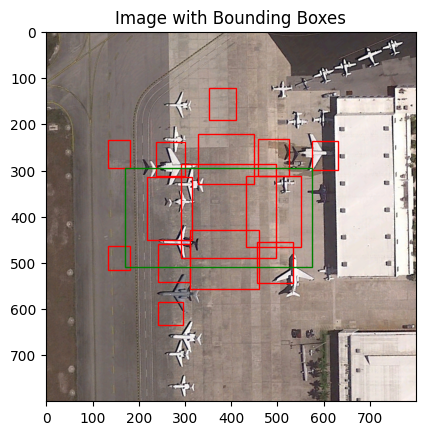

In [24]:
plot_image(test_dataset[0][0].permute(1,2,0).to("cpu"), pred_boxes_first_image, target_boxes_first_image)

>   In red predictions, in green target